In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import mean, abs, power, pi, sin
from numpy.random import uniform, randint
from copy import deepcopy
from math import floor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from random import random

### Importing data

In [2]:
# to import the stored data
training = pd.read_csv('D:/tejas paper/final_training_df.csv')
training.head()

,Mean,SD,Kurtosis,sum,Skewness,max,min,range,RMS,Shape factor,condition
0,-1.166491,-0.641888,-0.631950,-1.166651,0.326382,-0.407618,1.058829,-0.740012,0.033720,-0.413015,5
1,0.389329,0.830822,1.604929,0.389247,0.082017,1.090784,-1.204128,1.196487,0.744678,-0.432032,3
2,1.439655,-0.488640,0.576646,1.439758,1.949726,0.773832,0.418404,0.236606,0.108506,-0.619835,1
3,-0.641116,-0.718663,-0.972769,-0.641185,-0.538460,-1.190899,0.873037,-1.093864,-0.003179,-0.486737,5
4,0.658361,-0.764562,-0.388668,0.658378,-0.370158,-0.387232,-0.437583,-0.008617,-0.024884,-0.598013,1


In [3]:
X_train = training.drop(['condition'], axis = 1)
Y_train = training['condition']

In [4]:
testing = pd.read_csv('D:/tejas paper/final_testing_df.csv')
testing.head()

,Mean,SD,Kurtosis,sum,Skewness,max,min,range,RMS,Shape factor,condition
0,-0.460915,-0.860746,-1.036939,-0.460855,-0.569580,-1.479807,1.343628,-1.483727,-0.071674,-0.520886,5
1,-0.224031,-0.100869,0.983163,-0.224191,0.073753,0.313520,-0.810453,0.567283,0.294995,-0.462754,4
2,-0.336128,0.531163,1.835477,-0.336130,2.019024,2.423654,-0.684162,1.700572,0.599914,-0.383252,4
3,0.331800,-0.372152,-0.920667,0.331941,-0.372720,-1.306980,0.615906,-1.035855,-1.967718,1.283732,0
4,0.415132,-0.535673,-0.822137,0.415019,-0.178914,-0.447551,0.309443,-0.402112,-1.968440,2.551908,0


In [5]:
X_test = testing.drop(['condition'], axis = 1)
Y_test = testing['condition']

### SMA

In [6]:
def initialize(N, dim):
    #if not isinstance(lb, list):
     #   lb = [lb for _ in range(dim)]
      #  ub = [ub for _ in range(dim)]
    #lb = np.asarray(lb)
    #ub = np.asarray(ub)
         
    #Initialize the locations of Harris' hawks
    #X = np.asarray([x*(ub-lb)+lb for x in uniform(0,1,(N, dim))])
    X = np.zeros((N, dim))
    
    reg_parameter = np.random.uniform(low = 0.0000001, high = 200, size = N)
    gam = np.random.uniform(low = 0.0000001, high = 50, size = N)

    for i in range(N):
        X[i, 0] = reg_parameter[i]
        X[i, 1] = gam[i]
    
    return X

In [7]:
def get_fitness(pos, X, Y):
    X = X.reset_index(drop=True)
    
    final_accuracy = []
    
    kf = KFold(n_splits = 10, random_state = None, shuffle = False)
    
    total_score = 0
    for train_index, test_index in kf.split(X):
        X_train_fold, X_cv_fold = X.iloc[train_index], X.iloc[test_index]
        Y_train_fold, Y_cv_fold = Y[train_index], Y[test_index]

        svm_model = SVC(C = pos[0], kernel='rbf', gamma = pos[1], verbose = False)
        svm_model.fit(X_train_fold, Y_train_fold)

        predicted_value = svm_model.predict(X_cv_fold)
        score = accuracy_score(Y_cv_fold, predicted_value)

        total_score = total_score + score
    acc = total_score/10
     
    return acc

In [8]:
def SMA(T, N, dim, X_train, Y_train):
    
    # initialize the location and Energy of the rabbit
    bestPosition = np.zeros(dim)
    bestFitness = float('-inf')  #change this to -inf for maximization problems
    worstFitness = float('inf')
    vc = 1
    
    # initialize location
    pos = initialize(N, dim)
    wt = np.zeros((N, dim))
    pop = pd.DataFrame(columns = ('position', 'fitness', 'weights'), index = [i for i in range(0, N)])
    for i in range(0, N):
            pop.iloc[i, 0] = pos[i, :]
            pop.iloc[i, 1] = 0
            pop.iloc[i, 2] = wt[i, :]
        
    # initialize convergence
    convergence_curve = np.zeros(T)
    
    #z = 0.03
    #z = 0.05
    z = 0.1
    
    for t in range(T):
        for i in range(0, N):
            # Check boundries       
            pop.iloc[i, 0][0] = np.clip(pop.iloc[i, 0][0], 0.0000001, 200)
            if pop.iloc[i, 0][1] < 0:
                pop.iloc[i, 0][1] = -pop.iloc[i, 0][1]
            else:
                pop.iloc[i, 0][1] = np.clip(pop.iloc[i, 0][1], 0.0000001, 50)
            
            # fitness of locations
            pop.iloc[i, 1] = get_fitness(pop.iloc[i, 0], X_train, Y_train)
        
        # set best location
        pop = pop.sort_values('fitness', ignore_index = True)
        worstFitness = pop.iloc[0, 1]
        bestFitness = pop.iloc[N-1, 1]
        bestPosition = pop.iloc[N-1, 0]
        
        S = bestFitness - worstFitness + epsilon
        
        ## updating W using eq 2.5
        for i in range(len(pos)):
            for j in range(dim):
                if i <= N/2:
                    pop.iloc[i, 2][j] = 1 + uniform() * np.log10(((bestFitness - pop.iloc[i, 1])/S) + 1)
                else:
                    pop.iloc[i, 2][j] = 1 - uniform() * np.log10(((bestFitness - pop.iloc[i, 1])/S) + 1)
                    
        a = np.arctanh(-((t+1)/T) + 1)
        b = 1 - (t + 1) / T
        
        ## updating location
        for i in range(len(pos)):
            if uniform() < z:
                #X1 = pop.iloc[i, 0]
                pop.iloc[i, 0][0] = random() * (200 - 0.0000001) + 0.0000001
                pop.iloc[i, 0][1] = random() * (50 - 0.0000001) + 0.0000001
                
                #fit_X1 = get_fitness(X1, X_train, Y_train)
                #if pop.iloc[i, 1] < fit_X1:
                    #pop.iloc[i, 0] = X1.copy()
            else:
                p = np.tanh(abs(pop.iloc[i, 1] - bestFitness))
                vb = uniform(-a, a, dim)
                vc = uniform(-1, 1, dim)
                #X1 = pop.iloc[i, 0]
                for j in range(dim):
                    r = random()
                    A = randint(0, N)
                    B = randint(0, N)
                    if r < p:
                        pop.iloc[i, 0][j] = bestPosition[j] + vb[j] * (pop.iloc[i, 2][j]*pop.iloc[A, 0][j] - pop.iloc[B, 0][j])
                    else:
                        pop.iloc[i, 0][j] = vc[j] * pop.iloc[i, 0][j]
                    pop.iloc[i, 0][0] = np.clip(pop.iloc[i, 0][0], 0.0000001, 200)
                    if pop.iloc[i, 0][1] < 0:
                        pop.iloc[i, 0][1] = -pop.iloc[i, 0][1]
                    else:
                        pop.iloc[i, 0][1] = np.clip(pop.iloc[i, 0][1], 0.0000001, 50)
                    
                    #fit_X1 = get_fitness(X1, X_train, Y_train)
                    #if pop.iloc[i, 1] < fit_X1:
                    #    pop.iloc[i, 0] = X1.copy()
                        
        convergence_curve[t] = bestFitness
        '''pop = pop.sort_values('fitness', ignore_index = True)
        
        current_bestPosition = pop.iloc[N-1, 0]
        current_bestFitness = pop.iloc[N-1, 1]
        
        #if bestFitness < current_bestFitness:
        bestPosition = current_bestPosition
        bestFitness = current_bestFitness'''
        
        if (t%1==0):
               print(f'At iteration {t} the best fitness is {bestFitness} and the best location is {bestPosition}')
    
    print(f'Best location is {bestPosition}')
    print(f'Best fitness is {bestFitness}')
        
        #loss_train.append(g_best[1])
    return convergence_curve, bestFitness, bestPosition

In [9]:
N = 100 # number of search agents
dim = 2
T = 50 # number of iterations
epsilon = 10*np.exp(-10)

In [10]:
#SMA(T, N, dim, X_train, Y_train)
SMA(T, N, dim, X_train, Y_train)

At iteration 0 the best fitness is 0.8960000000000001 and the best location is [5.02144427e+01 4.00104038e-02]
At iteration 1 the best fitness is 0.932 and the best location is [1.0000000e-07 6.0715499e-03]
At iteration 2 the best fitness is 0.944 and the best location is [9.69173267e+01 1.95602436e-02]
At iteration 3 the best fitness is 0.9480000000000001 and the best location is [1.00000000e-07 5.47425306e-02]
At iteration 4 the best fitness is 0.944 and the best location is [4.21154477 0.02732573]
At iteration 5 the best fitness is 0.9480000000000001 and the best location is [1.00000000e-07 3.15004241e-02]
At iteration 6 the best fitness is 0.9480000000000001 and the best location is [8.14708448 0.03603483]
At iteration 7 the best fitness is 0.952 and the best location is [6.2943555  0.03851917]
At iteration 8 the best fitness is 0.952 and the best location is [1.00000000e-07 7.90878773e-02]
At iteration 9 the best fitness is 0.952 and the best location is [1.00000000e-07 6.11240711

(array([0.896, 0.932, 0.944, 0.948, 0.944, 0.948, 0.948, 0.952, 0.952,
        0.952, 0.952, 0.952, 0.948, 0.948, 0.952, 0.948, 0.952, 0.948,
        0.948, 0.952, 0.952, 0.948, 0.952, 0.952, 0.952, 0.952, 0.952,
        0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952,
        0.952, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956,
        0.956, 0.956, 0.956, 0.956, 0.956]),
 0.9560000000000001,
 array([1.00000000e-07, 5.93906411e-02]))

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

############ N=50, z=0.03
# C=2.5094282 gamma=0.21972395  --> 10fold=95.2, training=97.6, testing=90
# C=8.88934972 gamma=0.05090859 --> 10fold=95.2, training=97.2, testing=88
# C=2.99006243 gamma=0.17470059 --> 10fold=95.2, training=97.6, testing=90
# C=3.051184 gamma=0.17334106   --> 10fold=95.2, training=97.6, testing=90
# C=2.84200156 gamma=0.19405703 --> 10fold=95.2, training=97.6, testing=90
# C=1.55366401 gamma=0.01917329  --> 10fold=95.6, training=88, testing=82
# C=1.04046026 gamma=0.00895812  --> 10fold=95.6, training=84.8, testing=84
#10.13577327, 0.0378745, 95.2, 96.8, 88
#3.00311178, 0.04710376, 95.6, 95.6, 90

############ N=50, z=0.05
# C=2.30672516 gamma=0.01386772 --> 10fold=95.6, training=88, testing=84
# C=3.3559318 gamma=0.11642638  --> 10fold=95.2, training=96.8, testing=90
# C=1.04046026 gamma=0.00895812 --> 10fold=95.6, training=84.8, testing=84
# C=4.81424431 gamma=0.03691801 --> 10fold=95.6, training=96.4, testing=90
# C=3.83112745 gamma=0.05840138 --> 10fold=95.2, training=96.8, testing=90

############ N=50, z=0.1
# C=3.41223382 gamma=0.03183166  --> 10fold=95.2, training=95.2, testing=90
# C=3.62436832 gamma=0.05771162 --> 10fold=95.6, training=96.4, testing=90
# C=3.23106531 gamma=0.09146647 --> 10fold=95.2, training=96.4, testing=88
# C= gamma=   --> 10fold=95.2, training=97.6, testing=90
# C= gamma= --> 10fold=95.2, training=97.6, testing=90

############ N=100, z=0.03
# C=10.14018732 gamma=0.03596144  --> 10fold=95.2, training=96.8, testing=88
# C=2.48500464 gamma=0.03647081 --> 10fold=95.6, training=94.8, testing=90
# C=6.35544493 gamma=0.03250747 --> 10fold=95.6, training=96.4, testing=90
# C= gamma=0.17334106   --> 10fold=95.2, training=97.6, testing=90
# C= gamma=0.19405703 --> 10fold=95.2, training=97.6, testing=90

############ N=100, z=0.1
# C=2.07016912 gamma=0.03459112  --> 10fold=95.2, training=94.8, testing=92
# C=3.05852319 gamma=0.01392317 --> 10fold=95.6, training=88.8, testing=86
# C=2.47431066 gamma=0.05532482 --> 10fold=95.6, training=95.6, testing=90
# C= gamma=0.17334106   --> 10fold=95.2, training=97.6, testing=90
# C= gamma=0.19405703 --> 10fold=95.2, training=97.6, testing=90

clf = SVC(kernel = 'rbf', C = 2.47431066, gamma = 0.05532482, verbose = 1)
clf.fit(X_train, Y_train)

test_predicted_output = clf.predict(X_test)
train_predicted_output = clf.predict(X_train)

testing_accuracy = accuracy_score(Y_test, test_predicted_output)
training_accuracy = accuracy_score(Y_train, train_predicted_output)

print("The TESTING ACCURACY IS:- ", testing_accuracy)
print('The TRAINING ACCURACY IS:- ', training_accuracy)

[LibSVM]The TESTING ACCURACY IS:-  0.9
The TRAINING ACCURACY IS:-  0.956


In [12]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
  
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100, '%')

 
    labels = [0,1,2,3,4,5]
    cmap=sns.light_palette("green")
  
    '''
    CONFUSION MATRIX
    '''
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Number of misclassified points  2.4 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


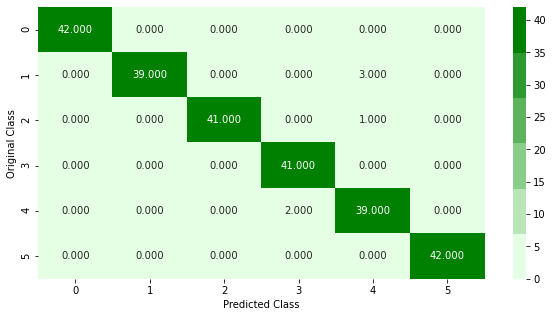

In [13]:
'''
FOR TRAINING DATA POINTS
'''
plot_confusion_matrix(Y_train, train_predicted_output)

Number of misclassified points  10.0 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


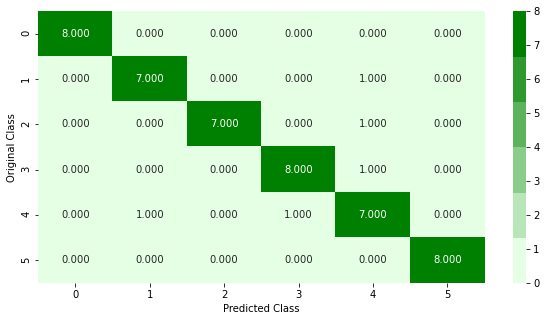

In [14]:
'''
FOR TESTING DATA POINTS
'''
plot_confusion_matrix(Y_test, test_predicted_output)